## Buy Now, Pay Later Project

The Buy Now, Pay Later (BNPL) Firm has begun offering a new “Pay in 5 Installments” feature and is going to onboard 100 merchants every year. This project focuses on these tasks:


- Overview of consumer and transaction data
- Analysis to find the 100 best merchants
- Recommendations for BNPL


## Table of Contents
1. [Data Overview](#dataset-overview)
    1. [Provided Dataset](#provided-dataset)
    2. [External Dataset](#external-datasets-overview)
2. [Visualisation](#visualisation)
3. [Assumptions & Limitations](#assumptions)
4. [Fraud Detection](#fraud-detection-model)
5. [Ranking System](#ranking-system)
    1. [Feature Selection](#feature-selection)
    2. [Ranking Criteria](#ranking-criteria)
    3. [Tag Categorisation](#split-merchants-into-4-segments)
6. [Insights & Recommendations](#insights--recommendation)
7. [Reflection](#reflection)

In [18]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('darkgrid')

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("ADS project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

### Dataset Overview
The dataset provided for this project includes:
- Transaction Dataset
- Consumer Dataset
- Merchant Dataset

External Dataset employed to provide more insights into the consumer analysis:
- [Australian postcode](https://www.matthewproctor.com/australian_postcodes)
- Income by SA2 Districts（ABS）
- SA2 shapefile (ABS)

#### Provided Dataset

In [14]:
transaction_sdf = spark.read.parquet('../data/tables/transactions_*/*')
print(f"Transaction dataset includes {transaction_sdf.count()} transaction records.")
print("Features included are: ")
transaction_sdf.printSchema()

Transaction dataset includes 14195505 transaction records.
Features included are: 
root
 |-- user_id: long (nullable = true)
 |-- merchant_abn: long (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)



In [15]:
consumer_sdf = spark.read.option("delimiter", "|").csv('../data/tables/tbl_consumer.csv', inferSchema =True, header=True)
print(f"Consumer dataset includes {consumer_sdf.count()} consumer records.")
print("Features included are: ")
consumer_sdf.printSchema()

Consumer dataset includes 499999 consumer records.
Features included are: 
root
 |-- name: string (nullable = true)
 |-- address: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- consumer_id: integer (nullable = true)



In [16]:
merchant_sdf = spark.read.csv("../data/curated/merchant.csv", inferSchema =True, header=True)
print(f"Merchant dataset includes {merchant_sdf.count()} merchant records.")
print("Features included are: ")
merchant_sdf.printSchema()

Merchant dataset includes 4026 merchant records.
Features included are: 
root
 |-- merchant_abn: long (nullable = true)
 |-- name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- take_rate: double (nullable = true)



#### External Datasets Overview

1. **Australian Postcode**  
Used to convert postcode of each region to their SA2 code for furture geospatial plotting

2. **Income by SA2 Districts**  
Used to analyse the purchase power of consumers from different regions which may correlate with final assessment of the merchants

In [20]:
postcode_SA2_sdf = spark.read.csv("../data/curated/processed_postcode.csv", inferSchema =True, header=True)
print("Features included are: ")
postcode_SA2_sdf.printSchema()

Features included are: 
root
 |-- postcode: integer (nullable = true)
 |-- SA2_code: integer (nullable = true)



In [18]:
income_sdf = spark.read.csv("../data/curated/processed_income.csv", inferSchema =True, header=True)
print("Features included are: ")
income_sdf.printSchema()


Features included are: 
root
 |-- SA2_code: string (nullable = true)
 |-- mean_total_income: integer (nullable = true)



### Visualisation
We inspect the relationship between each of the three features with respect to the location:
- Mean total income
- Number of Consumers
- Number of Transactions

**Mean Total Income Map**:  
The only three areas colored red in all of Australia are near Perth meaning that consumers here have relatively higher mean total income compared to the rest of Australia. Therefore, these areas may be more profitable for the BNPL company to target.

<img src="../plots/mean_total_income.png" width="400"/> 
<img src="../plots/mean_income_perth.png" width="400"/>


**Number of Consumer vs SA2 Map:**  
WA and SA have relatively more consumers than other state.

**Number of Transaction Map:**  
similar as number of consumer map which can be explained by the correlative between number of consumer and number of transaction (more consumers refer to more possible purchasing -> more transactions).

<img src="../plots/num%20consumers.png" width="400"/>
<img src="../plots/num%20transactions.png" width="400"/>

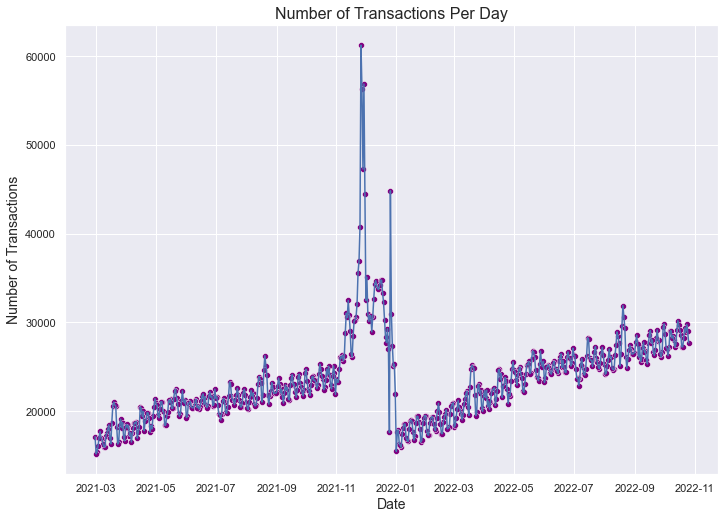

In [6]:
transaction_sdf = spark.read.parquet('../data/tables/transactions_*/*')\
        .withColumn(
            "order_datetime", 
            F.to_date(F.regexp_extract(F.split(F.input_file_name(), "=")[1], "(.*)/",1), "yyyy-MM-dd")
        )

# line plot of number of transactions each day
transaction_count_by_date = transaction_sdf.groupBy('order_datetime').count().toPandas()

sns.lineplot(x='order_datetime', y='count', data=transaction_count_by_date)
sns.scatterplot(x='order_datetime', y='count', data=transaction_count_by_date, color='purple')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Transactions', fontsize=14)
plt.title('Number of Transactions Per Day', fontsize=16)
plt.savefig('../plots/Number of Transactions Each Day.png')
plt.show()

**Observation**:  
The volume of transactions during Christmas and the Summer Holidays is higher compared to the rest of the year. Also, the yearly volume of transactions follows a similar trend. For example, the trends from March to November in each year are similar. Our model will make an assumption based on these trends, which will be explained later.

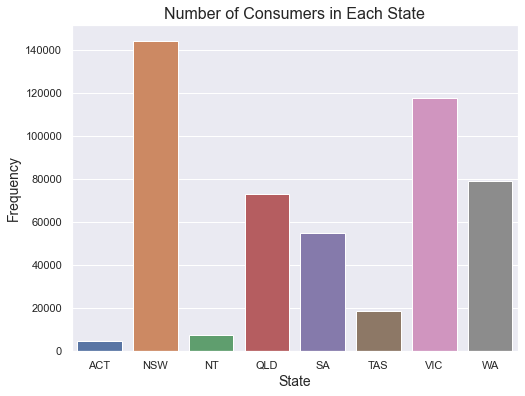

In [17]:
consumer_df = pd.read_parquet("../data/curated/consumer/")

# find number of consumers in each state
state_df = consumer_df[['state', 'user_id']].groupby(['state']).count()

sns.barplot(data=state_df, x=state_df.index, y="user_id")
plt.xlabel('State', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Number of Consumers in Each State', fontsize=16)
sns.set(rc={'figure.figsize':(6,8)})
plt.savefig('../plots/consumer distribution.png')
plt.show()

**Observation:**  
NSW and Victoria have the most consumers. Hence, the company may earn more profits in these two states.

### Assumptions
1. Transactions follow similar pattern each year

2. Transactions other than the days listed in the delta files for both customer and merchant have 1% fraud rate

### Limitations
1. Limited transaction data (from 2021-02-28 to 2022-10-26)

2. Missing values: 2 postcodes out of 3167 postcodes do not have a corresponding SA2 code


### Fraud Detection Model
A 5% fraud probability benchmark was set to label a transaction as fraud or not. The two given delta files (covers transactions from 2021-02 to 2022-02) were used to train a logistic model to classify whether other transactions are fraud. Then all fraud transactions were removed from the full dataset before proceeding to build the ranking system.

### Ranking System
To select the best merchants to cooperate, we first summarise each merchant’s data into several features, including 
1. Total number of consumers
2. Average transaction dollar value
3. Total number of transactions
4. Mean income of consumers
5. Revenue level
6. BNPL revenue = take rate * total transaction
7. Number of distinct postcode
8. Tag

We then use merchants’ historical data to predict their future business prospects,
1. Total number of consumers
2. BNPL revenue
3. Total number of transactions

#### Feature Selection
- Categorical variables: tag, revenue level  
use anova test to examine the significance of these variables in predicting each target variable

- Continuous variables  
calculate the pearson correlation of each pair of continuous variables

In [19]:
train_df = pd.read_parquet('../data/curated/train_data/')
model = ols('y_total_num_consumer ~ C(tag) + C(revenue_level)', data=train_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(tag),1.053317e+09,23.0,10.807923,2.577792e-38
C(revenue_level),1.469519e+07,4.0,0.867015,4.828556e-01
Residual,1.587715e+10,3747.0,NaN,NaN


In [20]:
model = ols('y_total_revenue ~ C(tag) + C(revenue_level)', data=train_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(tag),1.346792e+14,23.0,2.352075,2.797096e-04
C(revenue_level),2.175894e+14,4.0,21.850229,7.579153e-18
Residual,9.328363e+15,3747.0,NaN,NaN


In [21]:
model = ols('y_total_num_transaction ~ C(tag) + C(revenue_level)', data=train_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(tag),2.395748e+09,23.0,5.381250,1.734586e-15
C(revenue_level),7.439283e+07,4.0,0.960818,4.277650e-01
Residual,7.252935e+10,3747.0,NaN,NaN


**Observation**:  
"tag" is significant in all models, whereas "revenue level" is not a significant feature in predicting total number of consumers and transactions.

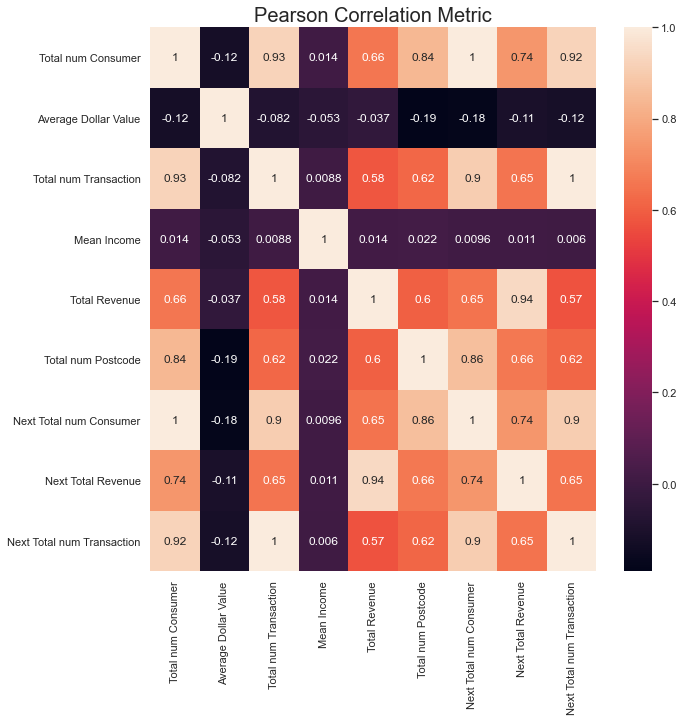

In [22]:
# pearson correlation heatmap for continuous variables
x_axis = ["Total num Consumer", "Average Dollar Value", "Total num Transaction", "Mean Income", "Total Revenue", "Total num Postcode", "Next Total num Consumer", "Next Total Revenue", "Next Total num Transaction"]
plt.figure(figsize = (10, 10))
sns.heatmap(train_df.drop('merchant_abn', axis=1).corr(), annot = True, annot_kws={"size": 12}, xticklabels=x_axis, yticklabels=x_axis)
plt.title('Pearson Correlation Metric', size = 20)
plt.savefig("../plots/Pearson Correlation Metric")

**Observation**:  
"Mean income" and "avergate dollar value" have little correlation with target variables. Therefore, they can be excluded in models.

#### Ranking Criteria
After summarizing each merchant's data, we fit a machine learning model on each of the target variable:
- BNPL revenue: Multi-layer Perceptron

- Number of consumers: Linear Regression

- Number of transactions: Linear Regression

<br>
The ranking system utilises predicted number of consumers and transactions as well as revenue that the company could gain from the merchant next year. We also give each merchant a score within 0-100. The ranking score is calculated as follows:

1. Standardise each attribute using min-max normalization 

2. Total number of consumers * 30%

3. BNPL revenue * 40%

4. Total number of transactions * 30%

As we take the revenue that BNPL firm could earn as the highest priority, this feature is assigned the largest weight.
Number of consumers and transaction volume are included since they are considered to be positively related with a merchant’s stability and long-term revenue.


#### Split Merchants into 4 Segments
Based on [Merchant Cateogry Groups by ANZ](https://www.anz.com/Documents/Business/CommercialCard/Merchant_cateogry_codes_control.pdf), we devide all merchant into 4 categories.

1. Health service: health, optician

2. Recreational good retailing: bicycle, books, stationary, hobby, tent, digital goods, 

3. Personal & household good retail: antique, watch, jewellery, music, artist supply, gift, art dealer, florists, furniture, shoe, garden supply, 

4. Technical & machinery service: cable, telecom, computer, equipment, motor

### Insights & Recommendation

<img src="../plots/Tag and Segments Distribution in TOP100.png" width="800"/>

**Insight (1):**  
Within the Top 100 merchants, the segment of **Personal and Household retail** is the largest at 43%. Possible reasons of this observation could be:
- It covers the most individual tags and merchants. 
- For individual consumers, the purchase of personal and household goods are always more frequent and sustainable in the long-term.

Therefore these merchants are more likely to run a risk-less business as the demand is always large. 

For the individual tags, the top two that take up the most weights are **‘tent’** and **‘computer’**, 14 and 12 out of 100 respectively. This may be because tent merchants often have high customer volume and flow while computer merchants are related to greater transaction values.

<br>

**Recommendation (1):**  
We recommend the BNPL company to investment in the Personal & Household retailers to receive risk-less benefits. Also, this final ranking could be considered as an insight into and assessment of whether a particular business behaviour is likely to lead to large revenues and benefits and in turn, future business opportunities. 

<img src="../plots/Average Total Revenue of Merchants for Each Segment.png" width="500"/>

**Insight (2):**  
By comparing the average total revenue of Top 100 merchants with that of all other merchants, BNPL company’s profits can be more than **10 times higher** if they focus their resources on cooperating with the top merchants. Consequently, it shows that our final result is reliable in detecting what merchants are more likely to bring high return in each segment. 

**Recommendation (2):**  
We strongly recommend the company to construct a similar system which consists of both predictions of merchants’ future business prospects and a ranking system based on that. This allows the company to pool all resources to maximize benefits. 

**Recommendation (3):**  
Based on our previous geospatial analysis, we recommend the company to focus on merchants and businesses in Perth, NSW, VIC as these regions relate to the highest income and number of consumers.

### Reflection
Some difficulties we ran into: 
- **Limited computing resources and time constraint:** Due to millions of transaction data, we spent more time building and running our code

- **Limited data:** We only managed to get less than two years of data, which may present a year's pattern, but we cannot see it in the long term.

If we could address these issues, we could have build better models and receive more accurate results.

In [27]:
# TODO: Do we have to include code for plotting visualisations or can we just post images?
# TODO: Do we need to include code for modelling?